# Removing duplicates

In [4]:
using Pkg
import Pkg; Pkg.add("Glob")

   Resolving package versions...
    Updating `~/Projects/DIVAnd-FAIR-EASE/Project.toml`
  [c27321d9] + Glob v1.3.1
    Updating `~/Projects/DIVAnd-FAIR-EASE/Manifest.toml`
  [c27321d9] + Glob v1.3.1


In [5]:
using DIVAnd
using NCDatasets
using Dates
using Glob
using PyPlot
const plt = PyPlot

PyPlot

In [6]:
datadir = "../data/NorthAdriatic/"
datafilelist = glob(joinpath(datadir, "*.nc"))
nfiles = length(datafilelist)
@info("Working on $(nfiles) files")
@show datafilelist

[ Info: Working on 4 files


datafilelist = ["../data/NorthAdriatic/NorthAdriaticSea_CORA_Profile_TEMP_19500101-20240101_0-500m.nc", "../data/NorthAdriatic/NorthAdriaticSea_Euro-Argo_TEMP_19500101-20240101_0-500m.nc", "../data/NorthAdriatic/NorthAdriaticSea_SeaDataNet_CDI_TS_ITS-90_water_temperature_19500101-20240101_0-500m.nc", "../data/NorthAdriatic/NorthAdriaticSea_World_Ocean_Database_Temperature_19500101-20240101_0-500m.nc"]


4-element Vector{String}:
 "../data/NorthAdriatic/NorthAdri" ⋯ 22 bytes ⋯ "EMP_19500101-20240101_0-500m.nc"
 "../data/NorthAdriatic/NorthAdri" ⋯ 19 bytes ⋯ "EMP_19500101-20240101_0-500m.nc"
 "../data/NorthAdriatic/NorthAdri" ⋯ 47 bytes ⋯ "ure_19500101-20240101_0-500m.nc"
 "../data/NorthAdriatic/NorthAdri" ⋯ 37 bytes ⋯ "ure_19500101-20240101_0-500m.nc"

In [7]:
# Allocate vectors of vectors
lonall = Vector{Vector{Float64}}(undef, nfiles)
latall = Vector{Vector{Float64}}(undef, nfiles)
timesall = Vector{Vector{DateTime}}(undef, nfiles)
depthall = Vector{Vector{Float64}}(undef, nfiles)
obsall = Vector{Vector{Float64}}(undef, nfiles)

for (iii, datafile) in enumerate(datafilelist)
    @info("Working on file $(basename(datafile))")
    
    dateref = Dates.DateTime(1950, 1, 1)
    
    if occursin("World_Ocean_Database", basename(datafile))
        dateref = Dates.DateTime(1770, 1, 1)
    elseif occursin("EMODnet Chemistry", basename(datafile)) 
        dateref = Dates.DateTime(1921, 1, 1)
    end
    
    NCDataset(datafile, "r") do ds
        # print(ds)
        lonall[iii] = ds["LONGITUDE"][:]
        latall[iii] = ds["LATITUDE"][:]
        depthall[iii] = ds["DEPTH"][:]
        
        if ds["TIME"][:] isa Vector{Float64}
            @info(extrema(ds["TIME"][:]))
            # Convert to DateTime
            timesall[iii] = dateref .+ Millisecond.(round.(ds["TIME"][:] .* 86400 .* 1000))
            
        elseif ds["TIME"][:] isa Vector{String}
            @info("Need to convert to Datatime object")
            df = dateformat"y-m-dTH:M:S"
            timesall[iii] = DateTime.(ds["TIME"][:], df)
        end
        # 
        
        obsall[iii] = ds[keys(ds)[1]][:]
    end
end

[ Info: Working on file NorthAdriaticSea_CORA_Profile_TEMP_19500101-20240101_0-500m.nc
[ Info: (35.791666666666664, 24454.402141203704)
[ Info: Working on file NorthAdriaticSea_Euro-Argo_TEMP_19500101-20240101_0-500m.nc
[ Info: (22003.481064814816, 27025.264814814815)
[ Info: Working on file NorthAdriaticSea_SeaDataNet_CDI_TS_ITS-90_water_temperature_19500101-20240101_0-500m.nc
[ Info: Need to convert to Datatime object
[ Info: Working on file NorthAdriaticSea_World_Ocean_Database_Temperature_19500101-20240101_0-500m.nc
[ Info: (65778.79166668653, 92768.265625)


## Some plots to check
### Time histograms

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


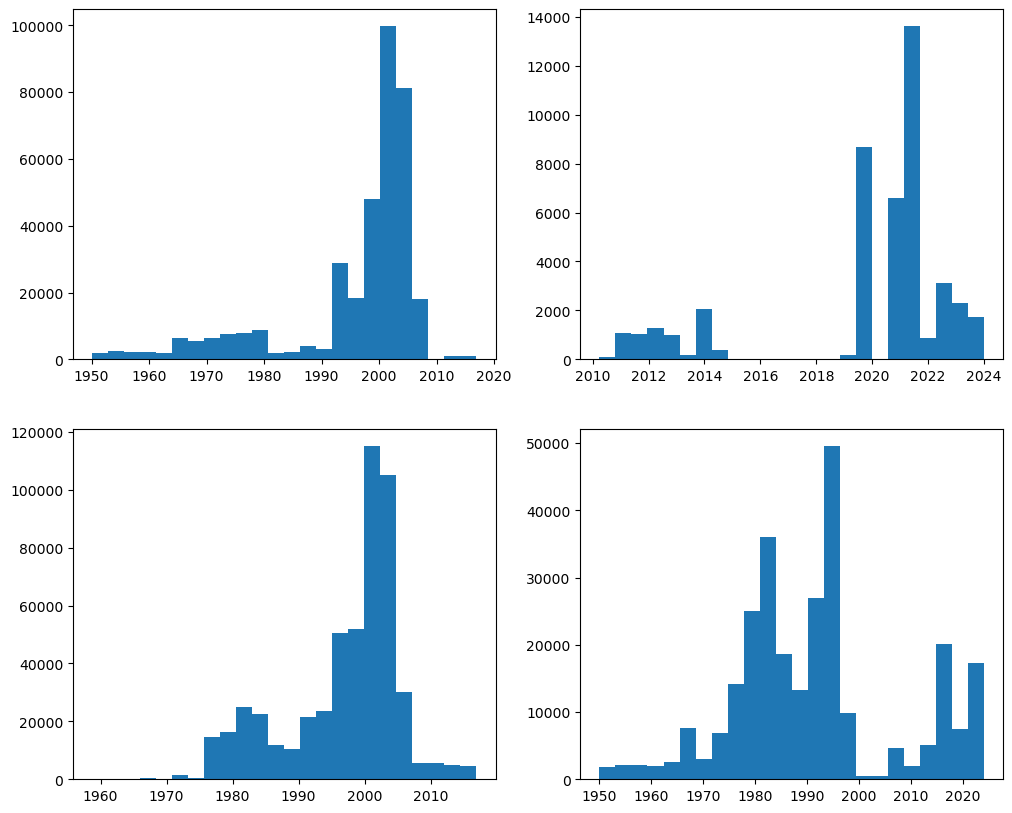

In [8]:
fig = plt.figure(figsize=(12, 10))
for ii = 1:nfiles
    ax = plt.subplot(2,2,ii)
    ax.hist(timesall[ii], bins=24)
end
plt.show()

### Map

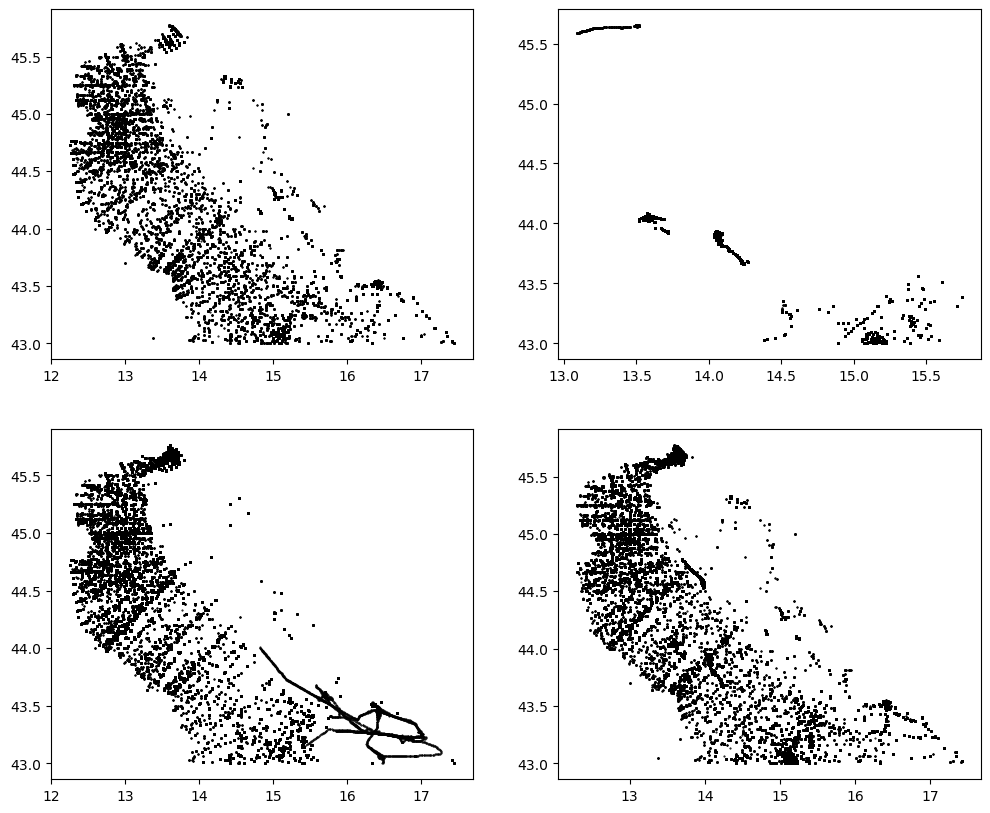

In [9]:
fig = plt.figure(figsize=(12, 10))
for ii = 1:nfiles
    ax = plt.subplot(2,2,ii)
    ax.plot(lonall[ii], latall[ii], "ko", ms=.5)
end
plt.show()

## Duplicate detection
### Set parameters

In [13]:
Δlon = 0.01
Δlat = 0.01
Δdepth = 0.1
Δtime = 0.0
Δvar = 0.01

0.01

In [18]:
function merge_datasets(lonall::Vector{Vector{Float64}}, latall::Vector{Vector{Float64}}, 
        depthall::Vector{Vector{Float64}}, timesall::Vector{Vector{DateTime}}, 
        obsall:: Vector{Vector{Float64}}, Δlon::Float64, Δlat::Float64, Δdepth::Float64, 
        Δtime::Float64, Δvar::Float64)
    
    pct = []

    dupl = DIVAnd.Quadtrees.checkduplicates((lonall[1], latall[1], depthall[1], timesall[1]), obsall[1],
                                            (lonall[2], latall[2], depthall[2], timesall[2]), obsall[2],
                                            (Δlon, Δlat, Δdepth, Δtime), Δvar);

    index = findall(.!isempty.(dupl))
    newpoints = findall(isempty.(dupl))
    ndupl = length(index)
    pcdupl = round(ndupl / length(lonall[2]) * 100; digits=2);
    push!(pct, pcdupl)
    @info("Number of possible duplicates: $ndupl")
    @info("Percentage of duplicates: $pcdupl%")

    # Merging
    lons = vcat(lonall[1], lonall[2][newpoints])
    lats = vcat(latall[1], latall[2][newpoints])
    depths = vcat(depthall[1], depthall[2][newpoints])
    times = vcat(timesall[1], timesall[2][newpoints])
    obs = vcat(obsall[1], obsall[2][newpoints])

    dupl2 = DIVAnd.Quadtrees.checkduplicates((lons, lats, depths, times), obs,
                                            (lonall[3], latall[3], depthall[3], timesall[3]), obsall[3],
                                            (Δlon, Δlat, Δdepth, Δtime), Δvar);

    index = findall(.!isempty.(dupl2))
    newpoints = findall(isempty.(dupl2))
    ndupl = length(index)
    pcdupl = round(ndupl / length(lonall[3]) * 100; digits=2);
    push!(pct, pcdupl)
    @info("Number of possible duplicates: $ndupl")
    @info("Percentage of duplicates: $pcdupl%")

    # Merging
    lons = vcat(lons, lonall[3][newpoints])
    lats = vcat(lats, latall[3][newpoints])
    depths = vcat(depths, depthall[3][newpoints])
    times = vcat(times, timesall[3][newpoints])
    obs = vcat(obs, obsall[3][newpoints])

    dupl3 = DIVAnd.Quadtrees.checkduplicates((lons, lats, depths, times), obs,
                                            (lonall[4], latall[4], depthall[4], timesall[4]), obsall[4],
                                            (Δlon, Δlat, Δdepth, Δtime), Δvar);

    index = findall(.!isempty.(dupl3))
    newpoints = findall(isempty.(dupl3))
    ndupl = length(index)
    pcdupl = round(ndupl / length(lonall[4]) * 100; digits=2);
    push!(pct, pcdupl)
    @info("Number of possible duplicates: $ndupl")
    @info("Percentage of duplicates: $pcdupl%")

    lons = vcat(lons, lonall[4][newpoints])
    lats = vcat(lats, latall[4][newpoints])
    depths = vcat(depths, depthall[4][newpoints])
    times = vcat(times, timesall[4][newpoints])
    obs = vcat(obs, obsall[4][newpoints])
    
    return lons::Vector{Float64}, lats::Vector{Float64}, depths::Vector{Float64}, 
    times::Vector{DateTime}, obs::Vector{Float64}, pct::Vector
end

merge_datasets (generic function with 1 method)

In [27]:
Δtime = 0.1
for Δlon in [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    Δlat = Δlon
    @time obslon, obslat, obsdepth, obstime, obsval, pct = merge_datasets(lonall, latall, depthall, timesall, 
        obsall, Δlon, Δlat, Δdepth, Δtime, Δvar);
    @info(Δlon, pct)
end

[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 302834
[ Info: Percentage of duplicates: 58.01%


 25.213045 seconds (9.03 M allocations: 3.621 GiB, 6.28% gc time)


[ Info: Number of possible duplicates: 180943
[ Info: Percentage of duplicates: 64.8%
┌ Info: 0.0005
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.01
└     64.8
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 302870
[ Info: Percentage of duplicates: 58.01%


 25.354877 seconds (9.15 M allocations: 3.624 GiB, 4.67% gc time)


[ Info: Number of possible duplicates: 195763
[ Info: Percentage of duplicates: 70.11%
┌ Info: 0.001
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.01
└     70.11
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 303396
[ Info: Percentage of duplicates: 58.11%


 26.935994 seconds (9.40 M allocations: 3.628 GiB, 4.35% gc time)


[ Info: Number of possible duplicates: 226233
[ Info: Percentage of duplicates: 81.02%
┌ Info: 0.005
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.11
└     81.02
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 303916
[ Info: Percentage of duplicates: 58.21%


 28.708437 seconds (9.40 M allocations: 3.628 GiB, 4.08% gc time)


[ Info: Number of possible duplicates: 226257
[ Info: Percentage of duplicates: 81.03%
┌ Info: 0.01
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.21
└     81.03
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 304571
[ Info: Percentage of duplicates: 58.34%


 34.508021 seconds (9.41 M allocations: 3.629 GiB, 3.53% gc time)


[ Info: Number of possible duplicates: 226340
[ Info: Percentage of duplicates: 81.06%
┌ Info: 0.05
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.34
└     81.06
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 304658
[ Info: Percentage of duplicates: 58.35%


 42.126140 seconds (9.42 M allocations: 3.632 GiB, 2.88% gc time)


[ Info: Number of possible duplicates: 226348
[ Info: Percentage of duplicates: 81.06%
┌ Info: 0.1
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.35
└     81.06
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Number of possible duplicates: 304739
[ Info: Percentage of duplicates: 58.37%


103.371591 seconds (9.43 M allocations: 3.646 GiB, 1.17% gc time)


[ Info: Number of possible duplicates: 226425
[ Info: Percentage of duplicates: 81.09%
┌ Info: 0.5
│   pct =
│    3-element Vector{Any}:
│      0.0
│     58.37
└     81.09
